In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import torch
import scipy as sp
from patsy import dmatrices
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
np.random.seed(123)

In [2]:
# 商業動態統計調査 / 時系列データ
# https://www.e-stat.go.jp/stat-search/files?stat_infid=000031387998
xls = pd.ExcelFile('./datasets/h2slt44j.xls') # 最終更新：2023-02-15 13:30
xls.sheet_names

['目次(Index)',
 '注',
 '販売額(value)年(CY)',
 '販売額(value)年度(FY)',
 '販売額(value)四半期(Q1-Q4)',
 '販売額(value)月次(Monthly)',
 '前年比(change)(CY)',
 '前年度比(change)(FY)',
 '前年同期比(change)(Q1-Q4)',
 '前年同月比(change) (Monthly)',
 '局別販売額(年)',
 '局別販売額(年度)',
 '局別販売額 (四半期)',
 '局別販売額(月次)',
 '局別前年比',
 '局別前年度比',
 '局別前年同期比',
 '局別前年同月比']

In [3]:
df = pd.read_excel(xls, sheet_name='販売額(value)月次(Monthly)', skiprows=6)
df

,時間軸コード,年月,sales of goods,D.I.Y. tools and materials,Electric appliances,Interiors,Household utensils and daily necessities,Gardening and exteriors,Pet and pet products,Car supplies and outdoor goods,Office products and hobbies,Others,Number of establishments,Month,Year
0,2014000101,2014年1月,243780,50939,22455,19858,50384,21179,17639,12170,14597,34559,4018,Jan,2014
1,2014000202,2014年2月,224436,48631,16898,16135,47392,23277,16666,10225,12612,32600,4028,Feb,2014
2,2014000303,2014年3月,340174,66835,23351,28500,79827,47143,22690,17491,18031,36306,4042,Mar,2014
3,2014000404,2014年4月,271777,58548,14081,20519,50710,55231,16908,15883,14849,25048,4055,Apr,2014
4,2014000505,2014年5月,296337,60780,13317,20861,56521,71495,19561,16204,12731,24867,4059,May,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,2022000808,2022年8月,274171,60492,16876,16445,61750,44101,23885,16893,10345,23384,4408,Aug,2022
104,2022000909,2022年9月,256939,62170,14645,14315,55855,42743,22911,12276,10340,21684,4417,Sep,2022
105,2022001010,2022年10月,284569,68542,20540,19702,57851,44566,24982,12954,11579,23853,4422,Oct,2022
106,2022001111,2022年11月,267282,66351,20401,17060,54833,37114,23479,11473,12304,24267,4430,Nov,2022


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 15 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   時間軸コード                                    108 non-null    int64 
 1   年月                                        108 non-null    object
 2   sales of goods                            108 non-null    int64 
 3   D.I.Y. tools and materials                108 non-null    int64 
 4   Electric appliances                       108 non-null    int64 
 5   Interiors                                 108 non-null    int64 
 6   Household utensils and daily necessities  108 non-null    int64 
 7   Gardening and exteriors                   108 non-null    int64 
 8   Pet and pet products                      108 non-null    int64 
 9   Car supplies and outdoor goods            108 non-null    int64 
 10  Office products and hobbies               108 non-

In [5]:
list(df.columns)

['時間軸コード',
 '年月',
 'sales of goods',
 'D.I.Y. tools and materials ',
 'Electric appliances',
 'Interiors',
 'Household utensils and daily necessities',
 'Gardening and exteriors ',
 'Pet and pet products',
 'Car supplies and outdoor goods',
 'Office products and hobbies',
 'Others',
 'Number of establishments',
 'Month',
 'Year']

In [6]:
# df.iloc[:, 3:-3][:1].sum().sum()

In [7]:
def tweak_diy(df):
    return (df
        .drop(columns=['時間軸コード', 'Month', 'Year', 'Number of establishments'])
        .rename(columns={'年月':'Date', \
                         'sales of goods':'sales_of_goods', \
                         'D.I.Y. tools and materials ':'DIY_tools_and_materials', \
                         'Gardening and exteriors ':'Gardening_and_exteriors', \
                         'Electric appliances':'Electric_appliances', \
                         'Household utensils and daily necessities':'Household_utensils_and_daily_necessities', \
                         'Pet and pet products':'Pet_and_pet_products', \
                         'Car supplies and outdoor goods':'Car_supplies_and_outdoor_goods', \
                         'Office products and hobbies':'Office_products_and_hobbies', \
                        })
        .astype({'Date': 'string'})
        .assign(Date=lambda _df: pd.to_datetime(_df['Date'].str.replace('年', '/').str.replace('月', ''), format='%Y-%m-%d'))
        .set_index(['Date'])
    )

In [8]:
diy = tweak_diy(df)
diy

,sales_of_goods,DIY_tools_and_materials,Electric_appliances,Interiors,Household_utensils_and_daily_necessities,Gardening_and_exteriors,Pet_and_pet_products,Car_supplies_and_outdoor_goods,Office_products_and_hobbies,Others
Date,,,,,,,,,,
2014-01-01,243780,50939,22455,19858,50384,21179,17639,12170,14597,34559
2014-02-01,224436,48631,16898,16135,47392,23277,16666,10225,12612,32600
2014-03-01,340174,66835,23351,28500,79827,47143,22690,17491,18031,36306
2014-04-01,271777,58548,14081,20519,50710,55231,16908,15883,14849,25048
2014-05-01,296337,60780,13317,20861,56521,71495,19561,16204,12731,24867
...,...,...,...,...,...,...,...,...,...,...
2022-08-01,274171,60492,16876,16445,61750,44101,23885,16893,10345,23384
2022-09-01,256939,62170,14645,14315,55855,42743,22911,12276,10340,21684
2022-10-01,284569,68542,20540,19702,57851,44566,24982,12954,11579,23853


In [9]:
diy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108 entries, 2014-01-01 to 2022-12-01
Data columns (total 10 columns):
 #   Column                                    Non-Null Count  Dtype
---  ------                                    --------------  -----
 0   sales_of_goods                            108 non-null    int64
 1   DIY_tools_and_materials                   108 non-null    int64
 2   Electric_appliances                       108 non-null    int64
 3   Interiors                                 108 non-null    int64
 4   Household_utensils_and_daily_necessities  108 non-null    int64
 5   Gardening_and_exteriors                   108 non-null    int64
 6   Pet_and_pet_products                      108 non-null    int64
 7   Car_supplies_and_outdoor_goods            108 non-null    int64
 8   Office_products_and_hobbies               108 non-null    int64
 9   Others                                    108 non-null    int64
dtypes: int64(10)
memory usage: 9.3 KB


In [10]:
# diy.isnull().sum()
diy.isna().any()

sales_of_goods                              False
DIY_tools_and_materials                     False
Electric_appliances                         False
Interiors                                   False
Household_utensils_and_daily_necessities    False
Gardening_and_exteriors                     False
Pet_and_pet_products                        False
Car_supplies_and_outdoor_goods              False
Office_products_and_hobbies                 False
Others                                      False
dtype: bool

In [11]:
diy.describe()

,sales_of_goods,DIY_tools_and_materials,Electric_appliances,Interiors,Household_utensils_and_daily_necessities,Gardening_and_exteriors,Pet_and_pet_products,Car_supplies_and_outdoor_goods,Office_products_and_hobbies,Others
count,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000
mean,278134.907407,60530.768519,19007.111111,19816.231481,60299.490741,41798.185185,21571.759259,14189.129630,13588.555556,27333.675926
std,30815.067055,6103.667786,5234.372450,3261.343300,7633.544029,14073.834821,2135.418215,2645.367434,2670.176781,4581.112196
min,213937.000000,47713.000000,13317.000000,13421.000000,46755.000000,18914.000000,16666.000000,9260.000000,9300.000000,21158.000000
25%,261840.750000,56441.500000,15125.250000,17901.500000,55397.750000,34471.250000,20251.500000,12249.500000,12077.000000,24373.750000
50%,274294.500000,60636.000000,17360.500000,19452.500000,59081.000000,39547.000000,21561.000000,13880.500000,12976.000000,25993.500000
75%,295373.250000,64774.000000,21015.500000,21654.000000,64680.250000,46654.750000,22974.250000,16220.250000,14615.750000,28269.750000
max,347051.000000,78118.000000,36084.000000,29631.000000,79827.000000,79273.000000,26906.000000,21476.000000,22383.000000,43088.000000


In [12]:
sum_list=[]
for _ in diy.columns[1:]:
    sum_list.append(diy[_].sum())
list(zip(diy.columns[1:], sum_list))

[('DIY_tools_and_materials', 6537323),
 ('Electric_appliances', 2052768),
 ('Interiors', 2140153),
 ('Household_utensils_and_daily_necessities', 6512345),
 ('Gardening_and_exteriors', 4514204),
 ('Pet_and_pet_products', 2329750),
 ('Car_supplies_and_outdoor_goods', 1532426),
 ('Office_products_and_hobbies', 1467564),
 ('Others', 2952037)]

In [13]:
diy.columns

Index(['sales_of_goods', 'DIY_tools_and_materials', 'Electric_appliances',
       'Interiors', 'Household_utensils_and_daily_necessities',
       'Gardening_and_exteriors', 'Pet_and_pet_products',
       'Car_supplies_and_outdoor_goods', 'Office_products_and_hobbies',
       'Others'],
      dtype='object')

In [14]:
diy['sqrt_DIY'] = np.sqrt(diy['DIY_tools_and_materials'])
diy['sqrt_Interiors'] = np.sqrt(diy['Interiors'])

In [15]:
diy.corr()

,sales_of_goods,DIY_tools_and_materials,Electric_appliances,Interiors,Household_utensils_and_daily_necessities,Gardening_and_exteriors,Pet_and_pet_products,Car_supplies_and_outdoor_goods,Office_products_and_hobbies,Others,sqrt_DIY,sqrt_Interiors
sales_of_goods,1.000000,0.804866,0.457550,0.817805,0.878287,0.603963,0.704895,0.625123,0.377453,0.320661,0.806978,0.819658
DIY_tools_and_materials,0.804866,1.000000,0.334729,0.487966,0.562190,0.594099,0.802061,0.323294,0.011281,0.022696,0.999468,0.496261
Electric_appliances,0.457550,0.334729,1.000000,0.649220,0.532922,-0.383220,0.400769,-0.082007,0.689703,0.774800,0.332143,0.630391
Interiors,0.817805,0.487966,0.649220,1.000000,0.796279,0.229852,0.398443,0.476838,0.663619,0.516285,0.491450,0.998151
Household_utensils_and_daily_necessities,0.878287,0.562190,0.532922,0.796279,1.000000,0.313182,0.706444,0.615450,0.430747,0.418805,0.566028,0.789204
Gardening_and_exteriors,0.603963,0.594099,-0.383220,0.229852,0.313182,1.000000,0.343185,0.598301,-0.261994,-0.401485,0.597230,0.251217
Pet_and_pet_products,0.704895,0.802061,0.400769,0.398443,0.706444,0.343185,1.000000,0.390145,-0.056623,0.041419,0.804104,0.402537
Car_supplies_and_outdoor_goods,0.625123,0.323294,-0.082007,0.476838,0.615450,0.598301,0.390145,1.000000,0.026979,-0.110218,0.331251,0.497535
Office_products_and_hobbies,0.377453,0.011281,0.689703,0.663619,0.430747,-0.261994,-0.056623,0.026979,1.000000,0.778509,0.014185,0.643254
Others,0.320661,0.022696,0.774800,0.516285,0.418805,-0.401485,0.041419,-0.110218,0.778509,1.000000,0.014834,0.484690


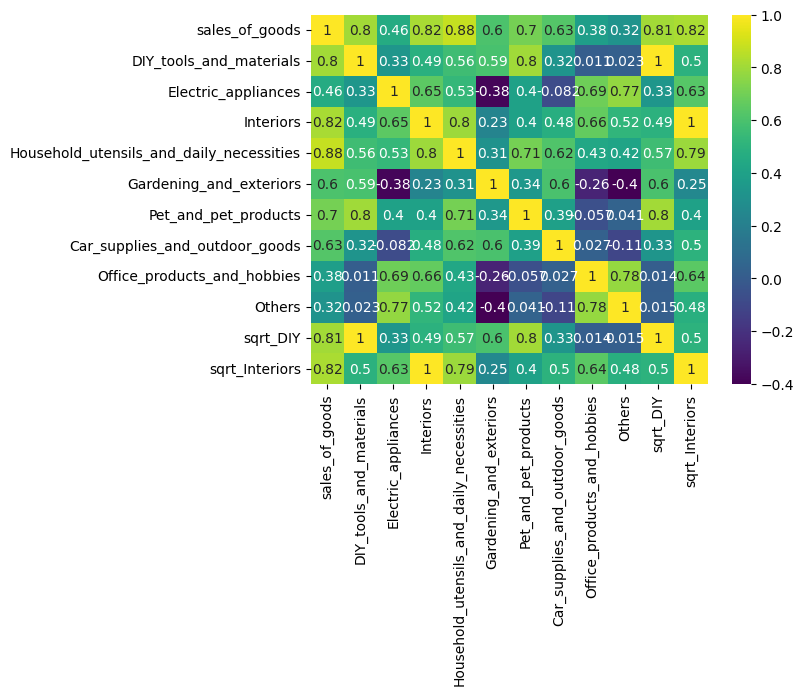

In [16]:
g = sns.heatmap(diy.corr(), cmap='viridis', annot=True)
plt.show()

In [17]:
# sns.pairplot(diy)
# plt.show()

In [18]:
# diy['DIY_tools_and_materials'].loc['2020-05-01'] = diy['DIY_tools_and_materials'].mean()

In [19]:
# diy['Interiors'] = np.log1p(diy['Interiors'].to_numpy())
# diy[['Interiors']]

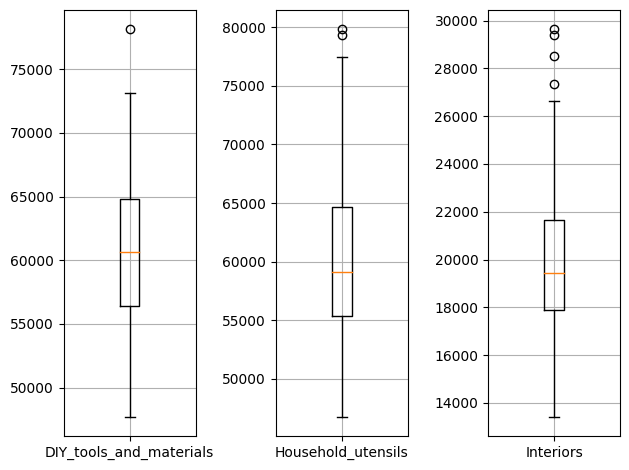

In [20]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
ax1.boxplot(diy['DIY_tools_and_materials'], labels=['DIY_tools_and_materials'])
ax1.grid()
ax2.boxplot(diy['Household_utensils_and_daily_necessities'], labels=['Household_utensils'])
ax2.grid()
ax3.boxplot(diy['Interiors'], labels=['Interiors'])
ax3.grid()

plt.tight_layout()
plt.show()

In [21]:
diy.corr().iloc[:1].T

,sales_of_goods
sales_of_goods,1.000000
DIY_tools_and_materials,0.804866
Electric_appliances,0.457550
Interiors,0.817805
Household_utensils_and_daily_necessities,0.878287
Gardening_and_exteriors,0.603963
Pet_and_pet_products,0.704895
Car_supplies_and_outdoor_goods,0.625123
Office_products_and_hobbies,0.377453
Others,0.320661


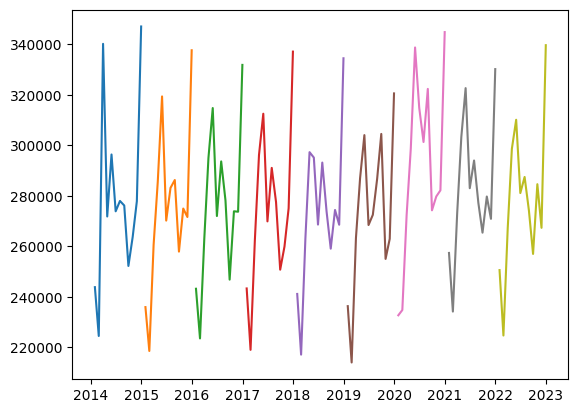

In [22]:
plt.plot(diy['sales_of_goods']['2014'].resample('M').mean())
plt.plot(diy['sales_of_goods']['2015'].resample('M').mean())
plt.plot(diy['sales_of_goods']['2016'].resample('M').mean())
plt.plot(diy['sales_of_goods']['2017'].resample('M').mean())
plt.plot(diy['sales_of_goods']['2018'].resample('M').mean())
plt.plot(diy['sales_of_goods']['2019'].resample('M').mean())
plt.plot(diy['sales_of_goods']['2020'].resample('M').mean())
plt.plot(diy['sales_of_goods']['2021'].resample('M').mean())
plt.plot(diy['sales_of_goods']['2022'].resample('M').mean())

plt.show()

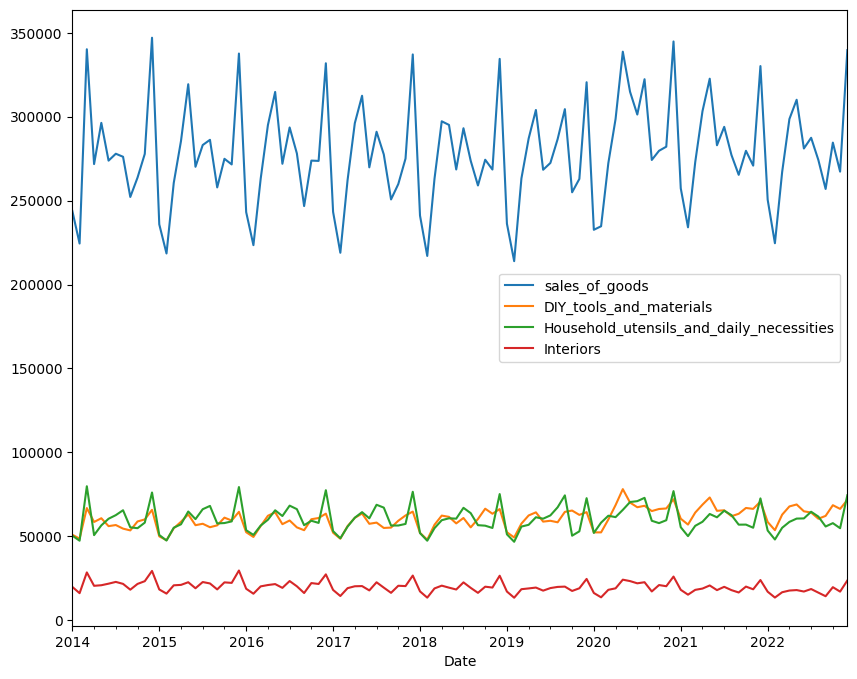

In [23]:
fig = plt.figure(figsize=(10, 8))
diy['sales_of_goods'].plot().legend()
diy['DIY_tools_and_materials'].plot().legend()
diy['Household_utensils_and_daily_necessities'].plot().legend()
diy['Interiors'].plot().legend()

plt.show()

In [24]:
f1 = 'sales_of_goods ~ DIY_tools_and_materials'
f2 = 'sales_of_goods ~ Household_utensils_and_daily_necessities'
f3 = 'sales_of_goods ~ Interiors'
f4 = 'sales_of_goods ~ DIY_tools_and_materials + Interiors'
f5 = 'sales_of_goods ~ Household_utensils_and_daily_necessities + Interiors'
f6 = 'sales_of_goods ~ DIY_tools_and_materials + Household_utensils_and_daily_necessities'
f7 = 'sales_of_goods ~ DIY_tools_and_materials + Household_utensils_and_daily_necessities + Interiors'
f8 = 'sales_of_goods ~ DIY_tools_and_materials + Household_utensils_and_daily_necessities + Electric_appliances + Interiors'
f9 = 'sales_of_goods ~ DIY_tools_and_materials + Electric_appliances + Interiors'
f10 = 'sales_of_goods ~ DIY_tools_and_materials + Electric_appliances + Interiors + Car_supplies_and_outdoor_goods'

diy1 = smf.ols(formula=f1, data=diy.loc['2015-01':'2022-09']).fit()
diy2 = smf.ols(formula=f2, data=diy.loc['2015-01':'2022-09']).fit()
diy3 = smf.ols(formula=f3, data=diy.loc['2015-01':'2022-09']).fit()
diy4 = smf.ols(formula=f4, data=diy.loc['2015-01':'2022-08']).fit()
diy5 = smf.ols(formula=f5, data=diy.loc['2015-01':'2022-09']).fit()
diy6 = smf.ols(formula=f6, data=diy.loc['2015-01':'2022-09']).fit()
diy7 = smf.ols(formula=f7, data=diy.loc['2015-01':'2022-09']).fit()
diy8 = smf.ols(formula=f8, data=diy.loc['2015-01':'2022-09']).fit()
diy9 = smf.ols(formula=f9, data=diy.loc['2015-01':'2022-09']).fit()
diy10 = smf.ols(formula=f9, data=diy.loc['2015-01':'2022-09']).fit()

# print('~'*10, f1, '~'*10)
# print(diy1.summary())
# print('~'*10, f2, '~'*10)
# print(diy2.summary())
# print('~'*10, f3, '~'*10)
# print(diy3.summary())
print(diy4.summary())
# print('~'*10, f5, '~'*10)
# print(diy5.summary())
# print('~'*10, f6, '~'*10)
# print(diy6.summary())
# print('~'*10, f7, '~'*10)
# print(diy7.summary())
print('~'*10, f8, '~'*10)
print(diy8.summary())
# print('~'*10, f9, '~'*10)
# print(diy9.summary())
# print('~'*10, f10, '~'*10)
# print(diy10.summary())

                            OLS Regression Results                            
Dep. Variable:         sales_of_goods   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     320.5
Date:                Mon, 27 Feb 2023   Prob (F-statistic):           2.15e-41
Time:                        15:18:51   Log-Likelihood:                -982.42
No. Observations:                  92   AIC:                             1971.
Df Residuals:                      89   BIC:                             1978.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1

In [25]:
y1, X1 = dmatrices(f1, diy.loc['2015-01':'2022-09'])
y2, X2 = dmatrices(f2, diy.loc['2015-01':'2022-09'])
y3, X3 = dmatrices(f3, diy.loc['2015-01':'2022-09'])
y4, X4 = dmatrices(f4, diy.loc['2015-01':'2022-09'])
y5, X5 = dmatrices(f5, diy.loc['2015-01':'2022-09'])
y6, X6 = dmatrices(f6, diy.loc['2015-01':'2022-09'])
y7, X7 = dmatrices(f7, diy.loc['2015-01':'2022-09'])
y8, X8 = dmatrices(f8, diy.loc['2015-01':'2022-09'])
y9, X9 = dmatrices(f9, diy.loc['2015-01':'2022-09'])
y10, X10 = dmatrices(f10, diy.loc['2015-01':'2022-09'])

model = LinearRegression()
score1 = cross_val_score(model, X1, y1, cv=5)
score2 = cross_val_score(model, X2, y2, cv=5)
score3 = cross_val_score(model, X3, y3, cv=5)
score4 = cross_val_score(model, X4, y4, cv=5)
score5 = cross_val_score(model, X5, y5, cv=5)
score6 = cross_val_score(model, X6, y6, cv=5)
score7 = cross_val_score(model, X7, y7, cv=5)
score8 = cross_val_score(model, X8, y8, cv=5)
score9 = cross_val_score(model, X9, y9, cv=5)
score10 = cross_val_score(model, X10, y10, cv=5)

print(score1.mean())
print(score2.mean())
print(score3.mean())
print(score4.mean())
print(score5.mean())
print(score6.mean())
print(score7.mean())
print(score8.mean())
print(score9.mean())
print(score10.mean())

0.5743589288200355
0.7204170271081812
0.5311785035535262
0.8503373378311571
0.7128331589254415
0.898635391065018
0.9236311501243483
0.9434742804321653
0.8629431317893331
0.9149099741655696


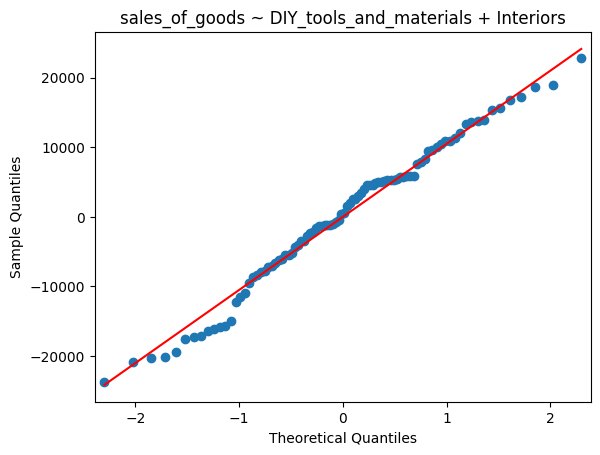

In [26]:
# sns.displot(diy4.resid)
sm.qqplot(diy4.resid, line='s')
plt.title(f4)
plt.show()

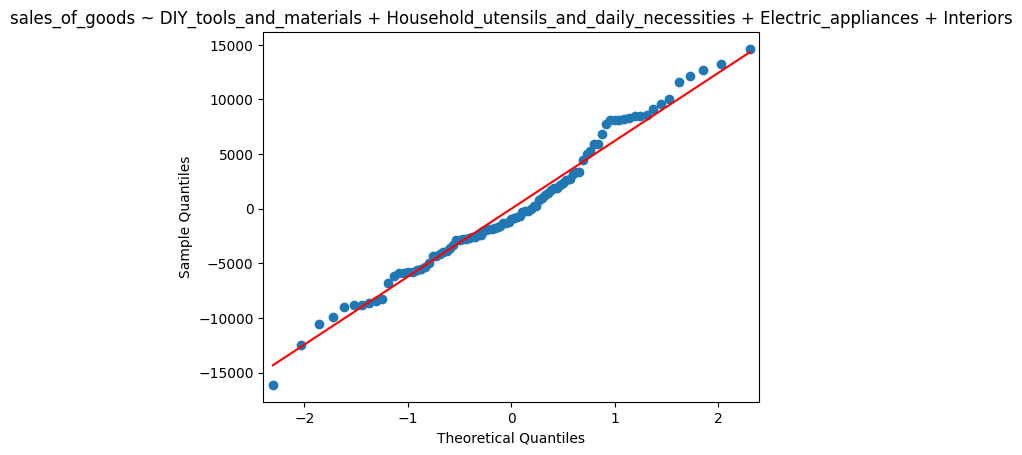

In [27]:
sm.qqplot(diy8.resid, line='s')
plt.title(f8)
plt.show()

In [28]:
# diy.reset_index().iloc[72:84] # 2020-01 ~ 2020-12
# diy.reset_index().iloc[84:96] # 2021
# diy.reset_index().iloc[13:72] # 2015-01 ~ 2019-12
# diy_a = diy.reset_index().iloc[13:72]
# diy_b = diy.reset_index().iloc[84:96]
# diy_c = pd.merge(diy_a, diy_b, how='outer').set_index('Date')
# diy_c
# diy_c[['DIY_tools_and_materials', 'Interiors']]
# diy_c[['sales_of_goods']]

In [29]:
X_train = diy[['DIY_tools_and_materials', 'Interiors']].loc['2015-01':'2022-09']
y_train = diy[['sales_of_goods']].loc['2015-01':'2022-09']

X_true = diy[['DIY_tools_and_materials', 'Interiors']].loc['2022-10':'2022-12']
y_true = diy[['sales_of_goods']].loc['2022-10':'2022-12']
X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=123)
lr = LinearRegression().fit(X_tr, y_tr)
pred_sales = (lr.intercept_ + lr.coef_[0][0]*diy['DIY_tools_and_materials'].loc['2022-12'] + lr.coef_[0][1]*diy['Interiors'].loc['2022-12']).to_numpy()
true_sales = torch.Tensor(diy[['sales_of_goods']].loc['2022-12'].to_numpy())
mae = mean_absolute_error(pred_sales, true_sales)
r2 = lr.score(X_true, y_true)
intercept = lr.intercept_
coefs = lr.coef_
print(mae, r2, pred_sales, true_sales, lr.intercept_, lr.coef_)

12719.333236102248 0.8381186255005295 [326919.6667639] tensor([[339639.]]) [16942.20137493] [[2.59420431 5.23476985]]


In [30]:
X_train = diy[['DIY_tools_and_materials', 'Household_utensils_and_daily_necessities', 'Electric_appliances', 'Interiors']].loc['2015-01':'2022-08']
y_train = diy[['sales_of_goods']].loc['2015-01':'2022-08']

X_true  = diy[['DIY_tools_and_materials', 'Household_utensils_and_daily_necessities', 'Electric_appliances', 'Interiors']].loc['2022-09':'2022-11']
y_true  = diy[['sales_of_goods']].loc['2022-09':'2022-11']

X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=123)
lr = LinearRegression().fit(X_tr, y_tr)
pred_sales = (lr.intercept_ + lr.coef_[0][0]*diy['DIY_tools_and_materials'].loc['2022-12'] + lr.coef_[0][1]*diy['Interiors'].loc['2022-12']).to_numpy()
true_sales = torch.Tensor(diy[['sales_of_goods']].loc['2022-12'].to_numpy())
mae = mean_absolute_error(pred_sales, true_sales)
r2 = lr.score(X_true, y_true)
intercept = lr.intercept_
coefs = lr.coef_
print(mae, r2, pred_sales, true_sales, lr.intercept_, lr.coef_) # multicolinearity

151174.10342951945 0.9579448615043387 [188464.89657048] tensor([[339639.]]) [-712.93382972] [[ 2.0735811   1.7114963  -1.02381384  3.47332391]]


In [31]:
my = diy['sales_of_goods'].loc[:'2022-10'].mean()
mx1 = diy['DIY_tools_and_materials'].loc[:'2022-10'].mean()
mx2 = diy['Interiors'].loc[:'2022-10'].mean()
s11 = ((diy['DIY_tools_and_materials'].loc[:'2022-10'] - mx1)**2).sum()
s22 = ((diy['Interiors'].loc[:'2022-10'] - mx2)**2).sum()
s12 = ((diy['DIY_tools_and_materials'].loc[:'2022-10'] - mx1)*(diy['Interiors'].loc[:'2022-10'] - mx2)).sum()
syy = ((diy['sales_of_goods'].loc[:'2022-10'] - my)**2).sum()
s1y = ((diy['DIY_tools_and_materials'].loc[:'2022-10'] - mx1)*(diy['sales_of_goods'].loc[:'2022-10'] - my)).sum()
s2y = ((diy['Interiors'].loc[:'2022-10'] - mx2)*(diy['sales_of_goods'].loc[:'2022-10'] - my)).sum()
sr = 2.6943*s1y + 5.1985*s2y
se = syy - sr
n=len(diy.index)-1;p=2;phi_e=n-1-p;phi_t=n-1
ve = se / phi_e

In [32]:
r_squared = sr / syy
r_adj = 1 - ((se/phi_e) / (syy/phi_t))
print(r_squared) #  statsmodels' R-squared: 0.883
print(r_adj) # statsmodels' Adj. R-squared: 0.881

0.8831140940521777
0.8808662881685657


In [33]:
mat = np.array([[s11, s12],[s12, s22]])
inv_mat = sp.linalg.inv(mat)
inv_mat

array([[ 3.43955741e-10, -3.12054781e-10],
       [-3.12054781e-10,  1.17962218e-09]])

In [34]:
s11_inv = inv_mat[0][0]
s12_inv = inv_mat[0][1]
s22_inv = inv_mat[1][1]

In [35]:
x1=66351;x2=17060
d = (n-1)*((((x1 - mx1)**2)*s11_inv) \
           + (2*(x1 - mx1)*(x2 - mx2)*s12_inv) \
           + (((x2 - mx2)**2)*s22_inv))
d

3.332792836861759

In [36]:
lev = (1/n) + (d/n-1)
lev

-0.9595066090012919

In [37]:
lev1 = 1 + (1/n) + (d/n-1)
lev1

0.04049339099870797

In [38]:
def f(alpha):
    # 商品販売額 = 19584.52379184 + 2.50815121(DIY用品) + 5.34599449(インテリア)
    x1=71675;x2=23695;beta_0=19584.52379184;beta_1=2.50815121;beta_2=5.34599449;y_true=339639
    n=len(diy.index)-1;p=2;phi_e=n-1-p
    my = diy['sales_of_goods'].loc['2015-01':'2022-09'].mean()
    mx1 = diy['DIY_tools_and_materials'].loc['2015-01':'2022-09'].mean()
    mx2 = diy['Interiors'].loc['2015-01':'2022-09'].mean()
    s11 = ((diy['DIY_tools_and_materials'].loc['2015-01':'2022-09'] - mx1)**2).sum()
    s22 = ((diy['Interiors'].loc['2015-01':'2022-09'] - mx2)**2).sum()
    s12 = ((diy['DIY_tools_and_materials'].loc['2015-01':'2022-09'] - mx1)*(diy['Interiors'].loc['2015-01':'2022-09'] - mx2)).sum()
    syy = ((diy['sales_of_goods'].loc['2014-01':'2022-12'] - my)**2).sum()
    s1y = ((diy['DIY_tools_and_materials'].loc['2015-01':'2022-09'] - mx1)*(diy['sales_of_goods'].loc['2015-01':'2022-09'] - my)).sum()
    s2y = ((diy['Interiors'].loc['2015-01':'2022-09'] - mx2)*(diy['sales_of_goods'].loc['2015-01':'2022-09'] - my)).sum()
    sr = beta_1*s1y + beta_2*s2y
    se = syy - sr
    ve = se / phi_e
    mat = np.array([[s11, s12],[s12, s22]])
    inv_mat = sp.linalg.inv(mat)
    s11_inv = inv_mat[0][0]
    s12_inv = inv_mat[0][1]
    s22_inv = inv_mat[1][1]
    d2 = (n-1)*((((x1 - mx1)**2)*s11_inv) \
           + (2*(x1 - mx1)*(x2 - mx2)*s12_inv) \
           + (((x2 - mx2)**2)*s22_inv))
    lev1 = 1 + (1/n) + (d2/n-1)
    rv = sp.stats.t(phi_e)
    interval = rv.isf(alpha/2)*np.sqrt(lev1*ve)
    y_hat = beta_0 + beta_1*x1 + beta_2*x2
    lower = y_hat - interval
    upper = y_hat + interval
    r2 = sr/syy
    mae = abs(y_hat - y_true)
    return [lower, upper], r2, y_hat, y_true, mae
print(f(0.05))
print(f(0.01))

([318702.05505498394, 333357.147363296], 0.7076640937286487, 326029.60120914, 339639, 13609.398790860025)
([316333.87983249594, 335725.322585784], 0.7076640937286487, 326029.60120914, 339639, 13609.398790860025)


In [39]:
diy

,sales_of_goods,DIY_tools_and_materials,Electric_appliances,Interiors,Household_utensils_and_daily_necessities,Gardening_and_exteriors,Pet_and_pet_products,Car_supplies_and_outdoor_goods,Office_products_and_hobbies,Others,sqrt_DIY,sqrt_Interiors
Date,,,,,,,,,,,,
2014-01-01,243780,50939,22455,19858,50384,21179,17639,12170,14597,34559,225.696699,140.918416
2014-02-01,224436,48631,16898,16135,47392,23277,16666,10225,12612,32600,220.524375,127.023620
2014-03-01,340174,66835,23351,28500,79827,47143,22690,17491,18031,36306,258.524660,168.819430
2014-04-01,271777,58548,14081,20519,50710,55231,16908,15883,14849,25048,241.966940,143.244546
2014-05-01,296337,60780,13317,20861,56521,71495,19561,16204,12731,24867,246.536001,144.433376
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,274171,60492,16876,16445,61750,44101,23885,16893,10345,23384,245.951215,128.238060
2022-09-01,256939,62170,14645,14315,55855,42743,22911,12276,10340,21684,249.339126,119.645309
2022-10-01,284569,68542,20540,19702,57851,44566,24982,12954,11579,23853,261.805271,140.363813


Train_Loss: 9010.9416
Test_Loss: 8218.2076


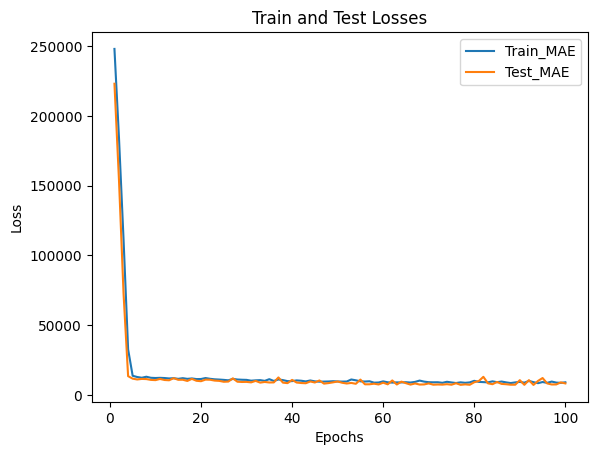

In [40]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

X_train = diy[['DIY_tools_and_materials', 'Interiors']].loc['2015-01':'2022-09'].to_numpy()
y_train = diy[['sales_of_goods']].loc['2015-01':'2022-09'].to_numpy()
X_true  = diy[['DIY_tools_and_materials', 'Interiors']].loc['2022-10':'2022-12'].to_numpy()
y_true  = diy[['sales_of_goods']].loc['2022-10':'2022-12'].to_numpy()

X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)
X_train = torch.Tensor(X_tr)
X_test = torch.Tensor(X_va)
y_train = torch.Tensor(y_tr)
y_test = torch.Tensor(y_va)

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(
    dataset=train_ds,
    batch_size=3,
    shuffle=True)

test_loader = DataLoader(
    dataset=test_ds,
    batch_size=3,
    shuffle=False)

in_features = 2
k = 200
out_features = 1
epochs = 100

class Net(nn.Module):
    def __init__(self, in_features, k, out_features):
        super(Net, self).__init__()
        self.linear1 = torch.nn.Linear(in_features, k)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(k, out_features)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x
    
net = Net(in_features, k, out_features).to(device)

loss_fn = nn.L1Loss()
optimizer = optim.Adam(net.parameters())

train_losses = []
test_losses = []
for i in range(epochs):
    train_loss = 0.0
    test_loss = 0.0
    
    net.train()
    for xx, yy in train_loader:
        xx = xx.to(device)
        yy = yy.to(device)
        
        optimizer.zero_grad()
        y_pred_prob = net(xx)
        loss = loss_fn(y_pred_prob, yy)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    batch_train_loss = train_loss / len(train_loader)   
    
    net.eval()
    with torch.no_grad():
        for xx, yy in test_loader:
            xx = xx.to(device)
            yy = yy.to(device)
            y_pred_prob = net(xx)
            loss = loss_fn(y_pred_prob, yy)
            test_loss += loss.item()      
               
    batch_test_loss = test_loss / len(test_loader)

    train_losses.append(batch_train_loss)
    test_losses.append(batch_test_loss)

print(f'Train_Loss: {batch_train_loss:.4f}')
print(f'Test_Loss: {batch_test_loss:.4f}')


fig, ax = plt.subplots()
ax.set_title('Train and Test Losses')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.plot(range(1, epochs+1), train_losses, label='Train_MAE')
ax.plot(range(1, epochs+1), test_losses, label='Test_MAE')
ax.legend()

plt.show()

torch.save(net.to(device).state_dict(), 'diy_net.pth')

In [41]:
import torch
from torch import nn, optim
# from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error

X_true = torch.Tensor(diy[['DIY_tools_and_materials', 'Interiors']][105:108].to_numpy())
y_true = torch.Tensor(diy[['sales_of_goods']].loc['2022-10':'2022-12'].to_numpy())

in_features = 2
k = 200
out_features = 1

class Net(nn.Module):
    def __init__(self, in_features, k, out_features):
        super(Net, self).__init__()
        self.linear1 = torch.nn.Linear(in_features, k)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(k, out_features)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net(in_features, k, out_features).to(device)
params = torch.load('./datasets/diy_net.pth', map_location=device)
net.load_state_dict(params)

net.eval()  
pred_sales = []
true_sales = []
with torch.no_grad():
        xx = X_true.to(device)
        yy = y_true.to(device)
        y_pred_proba = net(xx)
        pred_sales.append(y_pred_proba.view(-1).tolist())
        true_sales.append(yy.view(-1).tolist())
pred_sales = [e for l in pred_sales for e in l]
true_sales = [e for l in true_sales for e in l]
pred_sales = torch.tensor(pred_sales).reshape(-1, 1)
true_sales = torch.tensor(true_sales).reshape(-1, 1)
mae = mean_absolute_error(true_sales, pred_sales)
mse = ((pred_sales.reshape(-1) - true_sales.reshape(-1))**2).mean()
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(pred_sales)
print(true_sales)

MAE: 12188.78125
MSE: 150269440.0
tensor([[298603.2812],
        [278560.4688],
        [328385.4062]])
tensor([[284569.],
        [267282.],
        [339639.]])


In [42]:
# net.load_state_dict(torch.load('diy_net.pth', map_location=device))

In [43]:
def tweak_sales(df):
    return (df
        .drop(columns=['時間軸コード', 'Month', 'Year', 'Number of establishments', \
                       'D.I.Y. tools and materials ', 'Gardening and exteriors ', \
                       'Electric appliances', 'Household utensils and daily necessities', \
                       'Pet and pet products', 'Car supplies and outdoor goods', \
                       'Office products and hobbies', 'Interiors', 'Others'])
        .rename(columns={'年月':'Date', \
                         'sales of goods':'sales_of_goods',
                        })
        .astype({'Date': 'string'})
        .assign(Date=lambda _df: pd.to_datetime(_df['Date'].str.replace('年', '/').str.replace('月', ''), format='%Y-%m-%d'))
        .set_index(['Date'])
    )

In [44]:
sales_df = tweak_sales(df)
sales_df

,sales_of_goods
Date,
2014-01-01,243780
2014-02-01,224436
2014-03-01,340174
2014-04-01,271777
2014-05-01,296337
...,...
2022-08-01,274171
2022-09-01,256939
2022-10-01,284569


In [45]:
# sales_df['1ma'] = sales_df['sales_of_goods'].rolling(window=1, min_periods=0).mean()
sales_df['2ma'] = sales_df['sales_of_goods'].rolling(window=2, min_periods=0).mean()
sales_df['3ma'] = sales_df['sales_of_goods'].rolling(window=3, min_periods=0).mean()
sales_df['4ma'] = sales_df['sales_of_goods'].rolling(window=4, min_periods=0).mean()
sales_df['5ma'] = sales_df['sales_of_goods'].rolling(window=5, min_periods=0).mean()
sales_df['6ma'] = sales_df['sales_of_goods'].rolling(window=6, min_periods=0).mean()
sales_df

,sales_of_goods,2ma,3ma,4ma,5ma,6ma
Date,,,,,,
2014-01-01,243780,243780.0,243780.000000,243780.000000,243780.000000,243780.000000
2014-02-01,224436,234108.0,234108.000000,234108.000000,234108.000000,234108.000000
2014-03-01,340174,282305.0,269463.333333,269463.333333,269463.333333,269463.333333
2014-04-01,271777,305975.5,278795.666667,270041.750000,270041.750000,270041.750000
2014-05-01,296337,284057.0,302762.666667,283181.000000,275300.800000,275300.800000
...,...,...,...,...,...,...
2022-08-01,274171,280805.5,280889.666667,288190.750000,290274.200000,286409.666667
2022-09-01,256939,265555.0,272850.000000,274902.000000,281940.400000,284718.333333
2022-10-01,284569,270754.0,271893.000000,275779.750000,276835.400000,282378.500000


In [46]:
# plt.figure()
# plt.plot(sales_df['sales_of_goods'], label='sales_of_goods')
# # plt.plot(sales_df['1ma'], ls='--', label='1ma')
# plt.plot(sales_df['2ma'], ls='--', label='2ma')
# # plt.plot(sales_df['3ma'], ls='--', label='3ma')
# # plt.plot(sales_df['4ma'], ls='--', label='4ma')
# # plt.plot(sales_df['5ma'], ls='--', label='5ma')
# # plt.plot(sales_df['6ma'], ls='--', label='6ma')

# plt.title('sales_of_goods')
# plt.xlabel('Date')
# plt.ylabel('sales_of_goods')
# plt.legend()
# plt.show()

In [47]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_absolute_error

# ma2 = sales_df['2ma'].values.reshape(-1, 1)
# scaler = StandardScaler()
# ma2_std = scaler.fit_transform(ma2)
# print('ma:', ma2)
# print('ma_std:', ma2_std)

Train_Loss: 15731.6481
Test_Loss: 11511.9458


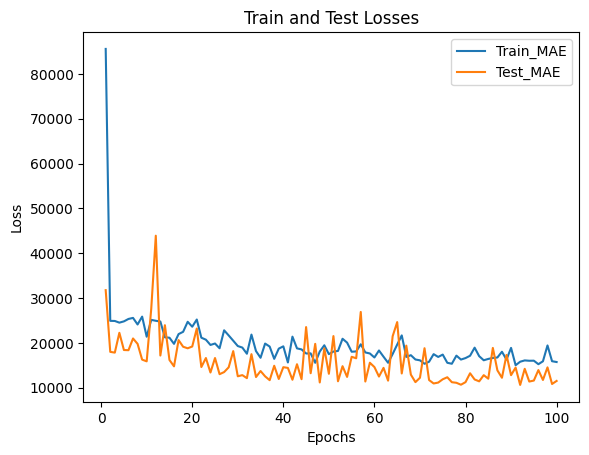

In [48]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

X_train = sales_df[['2ma', '3ma', '4ma', '5ma', '6ma']].loc['2015-01':'2021-12'].to_numpy()
X_test  = sales_df[['2ma', '3ma', '4ma', '5ma', '6ma']].loc['2022-01':'2022-12'].to_numpy()
y_train = sales_df[['sales_of_goods']].loc['2015-01':'2021-12'].to_numpy()
y_test  = sales_df[['sales_of_goods']].loc['2022-01':'2022-12'].to_numpy()

X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)
X_train = torch.Tensor(X_tr)
X_test = torch.Tensor(X_va)
y_train = torch.Tensor(y_tr)
y_test = torch.Tensor(y_va)

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(
    dataset=train_ds,
    batch_size=1,
    shuffle=True)

test_loader = DataLoader(
    dataset=test_ds,
    batch_size=1,
    shuffle=False)

in_features = 5
k = 200
out_features = 1
epochs = 100

class Net(nn.Module):
    def __init__(self, in_features, k, out_features):
        super(Net, self).__init__()
        self.linear1 = torch.nn.Linear(in_features, k)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(k, out_features)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x
    
net = Net(in_features, k, out_features).to(device)

loss_fn = nn.L1Loss()
optimizer = optim.Adam(net.parameters())

train_losses = []
test_losses = []
for i in range(epochs):
    train_loss = 0.0
    test_loss = 0.0
    
    net.train()
    for xx, yy in train_loader:
        xx = xx.to(device)
        yy = yy.to(device)
        
        optimizer.zero_grad()
        y_pred_prob = net(xx)
        loss = loss_fn(y_pred_prob, yy)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    batch_train_loss = train_loss / len(train_loader)   
    
    net.eval()
    with torch.no_grad():
        for xx, yy in test_loader:
            xx = xx.to(device)
            yy = yy.to(device)
            y_pred_prob = net(xx)
            loss = loss_fn(y_pred_prob, yy)
            test_loss += loss.item()      
               
    batch_test_loss = test_loss / len(test_loader)

    train_losses.append(batch_train_loss)
    test_losses.append(batch_test_loss)

print(f'Train_Loss: {batch_train_loss:.4f}')
print(f'Test_Loss: {batch_test_loss:.4f}')


fig, ax = plt.subplots()
ax.set_title('Train and Test Losses')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.plot(range(1, epochs+1), train_losses, label='Train_MAE')
ax.plot(range(1, epochs+1), test_losses, label='Test_MAE')
ax.legend()

plt.show()

# torch.save(net.to(device).state_dict(), 'diy_net.pth')